# 폐렴아 기다려라!
## 폐렴을 진단해보자

## 1. dataset
- 캐글의 chest X-Ray Images를 사용한다
- train, test, val 로 구성
    - 각 이미지 카테고리 폐렴/정상에 대한 하위 폴더를 포함한다. 
- 해당 이미지는 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X선 영상이다.

- 폐렴이란, 폐에 염증이 생기는 것.
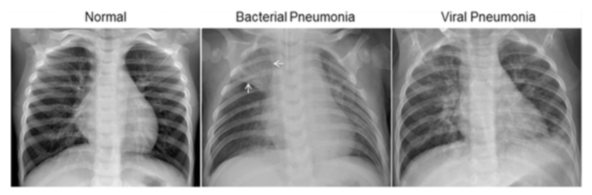

## 2. set-up
- 필요한 패키지들을 import한다.

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

- 필요한 변수 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


## 3.데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


- train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있습니다.

- 개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져온다.

- train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


- 정상보다 폐렴 이미지수가 3배 존재한다.
- 불균형은 차후에 조정한다.
- mini -batch로 작업할 수 있도록 해준다,

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

- 메모리 효율을 위하여 이미지 사이즈를 줄여준다.
    - decode_img 함수와 process_path 함수
- process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경. get_label을 이용해서 라벨 값을 가져옵니다.

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

- train 데이터 셋과 validation 데이터 셋을 만듭니다. num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있습니다.
- 이미지 리사이즈, 라벨링 잘 되었는지 확인

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


- test데이터셋

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


- Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다. tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.

- shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

- repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해준다.

- batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.

- prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

In [16]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3.데이터 시각화

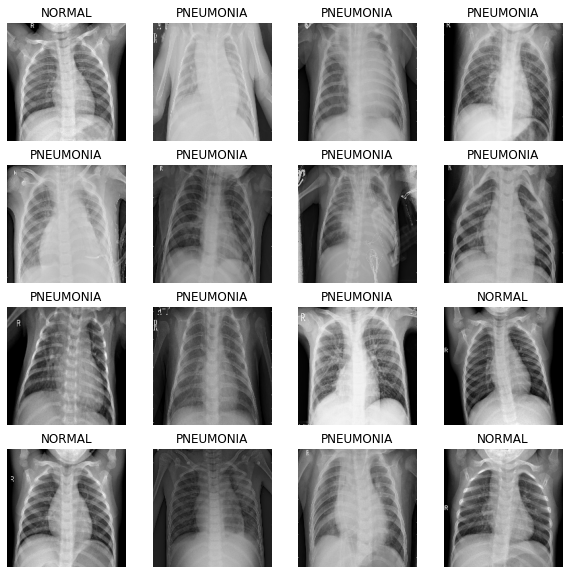

In [17]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. 모델링
### 4.1 CNN모델링 
- conv_block()의 구성은 Convolution을 두 번 진행
- Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결,  Max Pooling 수행

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [20]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 4.2 데이터 imbalance 처리
- 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있다
- Weight balancing이라는 테크닉사용. Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 6.모델 훈련
- "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다.
- 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용

In [23]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [25]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 104s 204ms/step - loss: 0.3813 - accuracy: 0.8233 - precision: 0.9512 - recall: 0.8037 - val_loss: 0.7335 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 52s 199ms/step - loss: 0.2184 - accuracy: 0.9150 - precision: 0.9739 - recall: 0.9104 - val_loss: 1.0728 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 52s 200ms/step - loss: 0.1981 - accuracy: 0.9284 - precision: 0.9730 - recall: 0.9294 - val_loss: 0.1173 - val_accuracy: 0.9577 - val_precision: 0.9498 - val_recall: 0.9947
Epoch 4/10
261/261 [==============================] - 53s 203ms/step - loss: 0.1741 - accuracy: 0.9337 - precision: 0.9790 - recall: 0.9308 - val_loss: 0.1105 - val_accuracy: 0.9663 - val_precision: 0.9828 - val_recall: 0.9712
Epoch 5/10
261/261 [==============================] - 53s 205ms/step - loss: 0.1664 - accur

### 4.3결과 확인
- 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 본다.

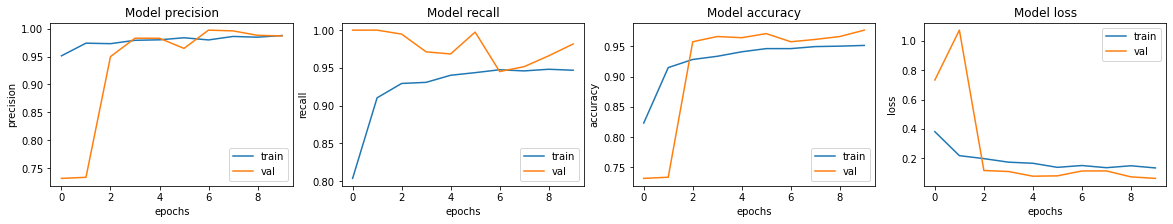

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [27]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 115ms/step - loss: 0.6403 - accuracy: 0.7949 - precision: 0.7579 - recall: 0.9872
Loss: 0.6403098702430725,
Accuracy: 0.7948718070983887,
Precision: 0.7578740119934082,
Recall: 0.9871794581413269


# 폐렴 진단기 성능 개선
- 라이브러리 버전 확인

In [65]:
import re
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [66]:
print(tensorflow.__version__)

2.6.0


 ## 1. setting , preprocess

In [160]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [224, 224]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


In [161]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


- 전체 데이터의 양이 적기 때문에 train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할한다.

In [162]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [163]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [164]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [165]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


- 클래스의 이름을 CLASS_NAMES변수에 담아준다.

In [166]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/data/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


In [167]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)|

In [168]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

- train 데이터 셋과 validation 데이터 셋을 만듭니다. num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있습니다.

In [169]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

- 이미지 리사이즈, 라벨링 잘 되었는지 확인

In [170]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  False


In [171]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + "/chest_xray/data/test/*/*"))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


- prepare_for_training 함수 정의
    - shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

    - repeat() : epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해준다.

    - batch() : BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.

    - prefetch() : 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

In [172]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [173]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 2.Augmentation

- X ray와 같은 의료영상의 특성상 육안으로 구분하기 어려운 미묘한 차이에 더해지는 노이즈 등의 부수효과가 오히려 학습에 방해를 줄 수 있다
    - 좌우 반전 Augmentation 도입하여 진행해본다

In [259]:
# def augment(image, label):
#     image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     return image, label  # 이미지와 레이블의 순서를 맞추어 반환합니다

# def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
#     ds = ds.map(
#             augment,
#             num_parallel_calls=2
#         )

#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE, drop_remainder=False)  # drop_remainder 인자 추가
#     ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

#     return ds

# # 데이터셋 로드 및 전처리
# train_aug_ds = prepare_for_training_aug(train_ds)
# val_aug_ds = prepare_for_training_aug(val_ds)

def augment(image, label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image, label

def resize_and_augment(image, label, input_shape):
    image = tf.image.resize(image, input_shape)  # 이미지 차원을 고정시킴
    image, label = augment(image, label)  # 데이터 증강을 수행합니다.
    return image, label

def prepare_for_training_aug(ds, input_shape, shuffle_buffer_size=1000):
    ds = ds.map(
            lambda image, label: resize_and_augment(image, label, input_shape),
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE, drop_remainder=False)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds

# 이미지 입력 차원 설정
input_shape = (224, 224)  # 또는 원하는 차원으로 설정

# 데이터셋 로드 및 전처리
train_aug_ds = prepare_for_training_aug(train_ds, input_shape)
val_aug_ds = prepare_for_training_aug(val_ds, input_shape)


In [260]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


## 3.Visualization
- 시각화
    - aug 미적용

(16, 224, 224, 3)
(16,)


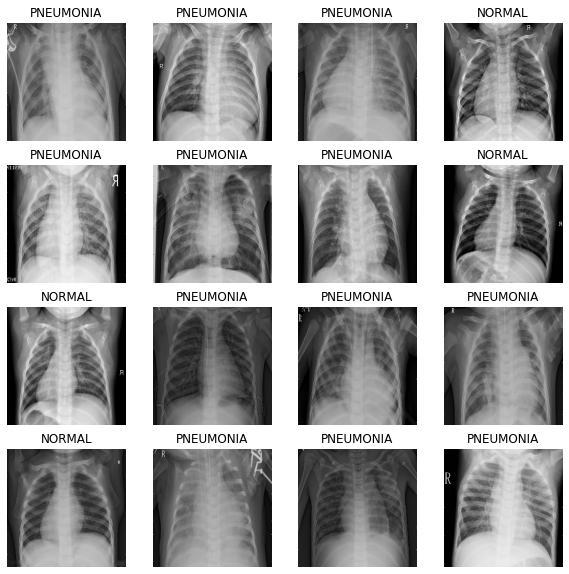

In [176]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    print(image_batch.shape)
    print(label_batch.shape)
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4.Model

- 구현에 필요한 라이브러리 불러옴

In [177]:
from keras import layers
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import MaxPool2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.models import Model
from keras.regularizers import l2


In [209]:
def conv2d_bn(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    x = Conv2D(filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same',
               use_bias=False,
               kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
    x = BatchNormalization()(x)
    return x

- ResNet 활성화 함수 구현

In [210]:
def conv2d_bn_relu(x, filters, kernel_size, weight_decay=.0, strides=(1,1)):
    layer = conv2d_bn(x, filters, kernel_size, weight_decay, strides)
    layer = Activation('relu')(layer)
    return layer

- ResidualBlock 구현<br>
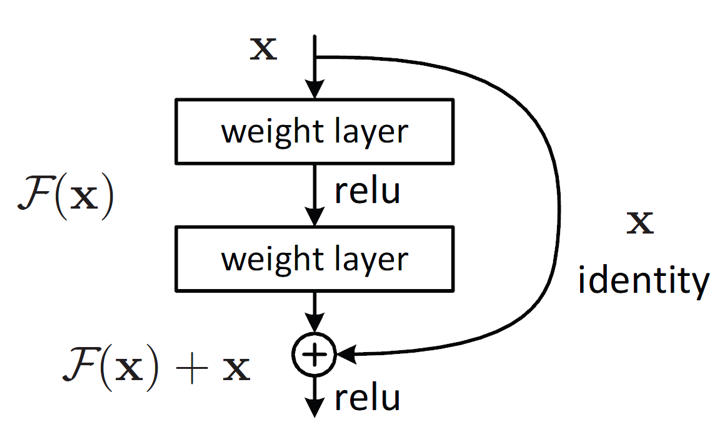

In [211]:
def ResidualBlock(x, filters, kernel_size, weight_decay, downsample=True):
    if downsample:
        residual_x = conv2d_bn(x, filters, kernel_size=1, strides=2)
        stride = 2
    else:
        residual_x = x
        stride = 1
    residual = conv2d_bn_relu(x,
                              filters=filters,
                              kernel_size=kernel_size,
                              weight_decay = weight_decay,
                              strides=stride
                             )
    residual = conv2d_bn(residual,
                              filters=filters,
                              kernel_size=kernel_size,
                              weight_decay = weight_decay,
                              strides=1
                             )
    out = layers.add([residual_x, residual])
    out = Activation('relu')(out)
    return out

- ResNet18 구현

In [212]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D

def ResNet18(classes, input_shape, weight_decay=1e-4):
    input = Input(shape=input_shape)
    x = input
    x = conv2d_bn_relu(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, strides=(1, 1))
    
    # conv2
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    
    # conv3
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    
    # conv4
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    
    # conv5
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = AveragePooling2D(pool_size=(4, 4), padding='valid')(x)
    x = Flatten()(x)
    x = Dense(classes, activation='softmax')(x)
    model = Model(input, x, name='ResNet18')
    return model

In [234]:
# 모델 생성
num_classes = 1
input_shape = (224, 224, 3)
weight_decay = 1e-4
resnet18 = ResNet18(classes=num_classes, input_shape=input_shape, weight_decay=weight_decay)

In [235]:
resnet18.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_255 (Conv2D)             (None, 224, 224, 64) 1728        input_26[0][0]                   
__________________________________________________________________________________________________
batch_normalization_255 (BatchN (None, 224, 224, 64) 256         conv2d_255[0][0]                 
__________________________________________________________________________________________________
activation_244 (Activation)     (None, 224, 224, 64) 0           batch_normalization_255[0][0]    
___________________________________________________________________________________________

- 생성된 모델을 시각화하여 본다.

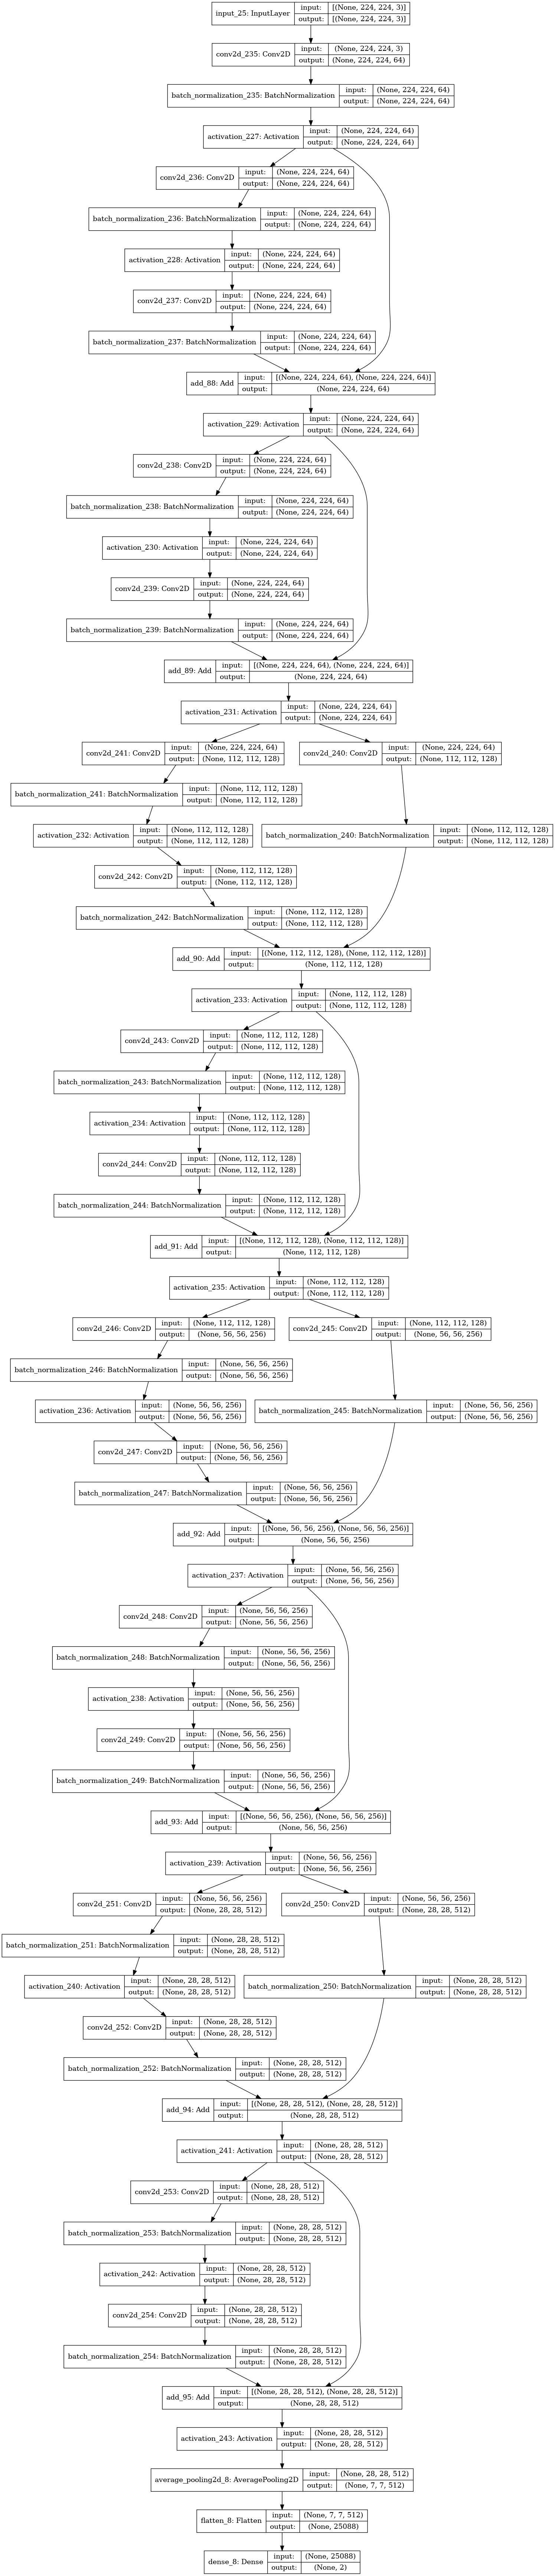

In [236]:
plot_model(model, show_shapes=True, to_file='residual_module.png')

## 5. data imbalance
- normal데이터와 Pneumonia 데이터 개수가 차이가 나기 때문에 imbalance를 처리해야 한다.
- 데이터가 많은 클래스에 치우쳐 학습하여 성능이 저하되는것을 막기 위하여 Weight balancing을 적용

In [232]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 6. model train
- 이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택한다.
- 라벨이 2개 "binary_cross entropy" loss를 사용, 옵티마이저는 adam을 사용
- 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용

In [237]:
with tf.device('/GPU:0'):
    model = ResNet18(classes=num_classes, input_shape=input_shape, weight_decay=weight_decay)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE
    )

Epoch 1/10
261/261 [==============================] - 203s 632ms/step - loss: 0.8196 - accuracy: 0.7438 - precision: 0.7438 - recall: 1.0000 - val_loss: 1.7067 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 165s 633ms/step - loss: 0.4801 - accuracy: 0.7445 - precision: 0.7445 - recall: 1.0000 - val_loss: 0.6183 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 165s 633ms/step - loss: 0.3665 - accuracy: 0.7433 - precision: 0.7433 - recall: 1.0000 - val_loss: 0.3234 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 165s 633ms/step - loss: 0.3143 - accuracy: 0.7438 - precision: 0.7438 - recall: 1.0000 - val_loss: 22.4590 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 165s 632ms/step - loss: 0.2799 - 

- test data 활용, 손실 및 정확도 수치 출력

In [239]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 147ms/step - loss: 1.6196 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.6195597648620605,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


- 성능 향상을 위해 LearningRate 튜닝

In [240]:
from keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch):
    new_lr = lr
    if epoch <= 91:
        pass
    elif epoch > 91 and epoch <= 137:
        new_lr = lr*0.1
    else:
        new_lr = lr * 0.01
    print('new lr:%.2e'%new_lr)
    return new_lr

reduce_lr = LearningRateScheduler(lr_scheduler)

In [263]:
with tf.device('/GPU:0'):
    history1 = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        callbacks=[reduce_lr]
    )

Epoch 1/5
new lr:1.00e-01
261/261 [==============================] - 169s 617ms/step - loss: 71.9224 - accuracy: 0.7435 - precision: 0.7435 - recall: 1.0000 - val_loss: 64.5365 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/5
new lr:1.00e-01
261/261 [==============================] - 161s 617ms/step - loss: 98.6975 - accuracy: 0.7435 - precision: 0.7435 - recall: 1.0000 - val_loss: 105.8680 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/5
new lr:1.00e-01
261/261 [==============================] - 160s 612ms/step - loss: 168.5264 - accuracy: 0.7443 - precision: 0.7443 - recall: 1.0000 - val_loss: 192.9313 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 4/5
new lr:1.00e-01
261/261 [==============================] - 161s 618ms/step - loss: 118.4913 - accuracy: 0.7440 - precision: 0.7440 - recall: 1.0000 - val_loss: 569.8223 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 5/5
new l

- test data 활용, 손실 및 정확도 수치 출력

In [264]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 150ms/step - loss: 101.2764 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 101.2763671875,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


## 7. Result & Visualization
- test data로 훈련된 모델을 평가
- 의료 영상 모델이기 때문에 recall도 함께 확인해본다.
- history 그래프로 Visualization 진행

- result

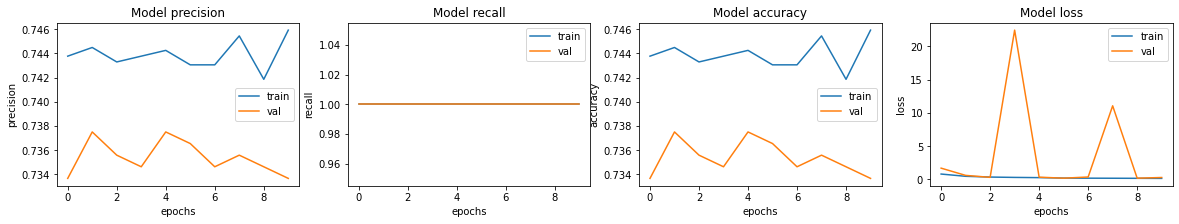

In [241]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

-  LearningRate 튜닝 result

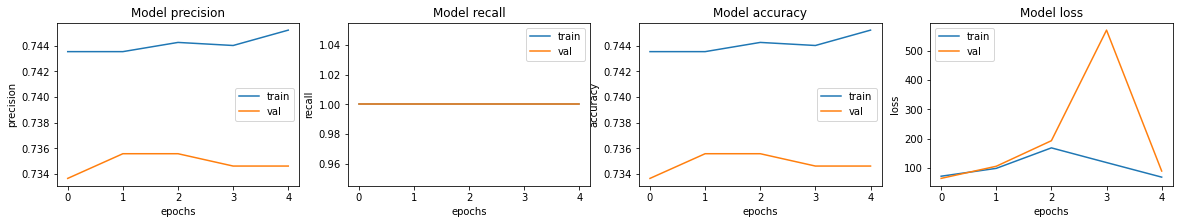

In [266]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history1.history[met])
    ax[i].plot(history1.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

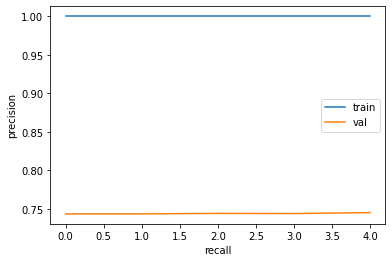

In [280]:
plt.plot(history1.history['recall'])
plt.plot(history1.history['precision'])
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend(['train', 'val'])
plt.show()

recall 성능에는 영향을 미치지 못한 것 확인

## 8. 회고 및 참고자료
- 입력 데이터의 사이즈와 배치를 잘 확인해야한다
- 모델 설계 시 해당 data의 class가 몇개인지 잘 확인하여 모델의 출력과 실제 레이블이 잘 일치하도록 해야한다.
- 학습되는 시간이 길어서 다양한 파라미터의 조정을 해보지 못했다.
- dead 커널이 발생하는 이유에 대해서 명확하게 알아내지 못했다.

### 참고자료
- chatGPT argument함수 차원 문제
```python
    def augment(image, label):
        image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
        return image, label

    def resize_and_augment(image, label, input_shape):
        image = tf.image.resize(image, input_shape)  # 이미지 차원을 고정시킴
        image, label = augment(image, label)  # 데이터 증강을 수행합니다.
        return image, label

    def prepare_for_training_aug(ds, input_shape, shuffle_buffer_size=1000):
        ds = ds.map(
                lambda image, label: resize_and_augment(image, label, input_shape),
                num_parallel_calls=tf.data.experimental.AUTOTUNE
            )

        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
        ds = ds.repeat()
        ds = ds.batch(BATCH_SIZE, drop_remainder=False)
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

        return ds

    # 이미지 입력 차원 설정
    input_shape = (224, 224)  # 또는 원하는 차원으로 설정

    # 데이터셋 로드 및 전처리
    train_aug_ds = prepare_for_training_aug(train_ds, input_shape)
    val_aug_ds = prepare_for_training_aug(val_ds, input_shape)
```
- kaggle, detection ResNet(https://www.kaggle.com/code/danushkumarv/pneumonia-detection-resnet)
